Base de datos: OASIS

In [12]:
pip install keras-tuner #--upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [133]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.ndimage as ndi
import scipy.ndimage as ndi
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Voy a tomar valores de imágenes que si tengan el label de CDR, para ello accedo al csv que proporciona la base de datos y selecciono 200

In [135]:
csv_file = '/content/drive/MyDrive/Proyecto_Patrones/oasis1_cross_sectional.csv'
df = pd.read_csv(csv_file)
filtered_df = df[df['CDR'].notna() & (df['CDR'] != 2)]
print(len(filtered_df))
#selected_rows = filtered_df.head(200)
labels = filtered_df['CDR'].tolist()
id_values = filtered_df['ID'].tolist()
print(len(labels))

233
233


Ahora voy a delimitar mi lista de folders a esos folders que si tienen un valor no nulo de CDR

In [136]:
base_folder_path = '/content/drive/MyDrive/Proyecto_Patrones/data/'
folders = []
for id_value in id_values:
    folder_path = os.path.join(base_folder_path, id_value)
    folders.append(folder_path)
print(f"Número de imágenes de {base_folder_path}: {len(folders)}")

Número de imágenes de /content/drive/MyDrive/Proyecto_Patrones/data/: 233


In [137]:
# main_folder = '/content/drive/MyDrive/Proyecto_Patrones/data/'
# folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# # Crear un diccionario para almacenar el conteo de archivos por carpeta
# folder_counts = {}

# for folder in folders:
#     folder_path = os.path.join(main_folder, folder)
#     # Contar los archivos en la carpeta
#     file_count = sum([len(files) for r, d, files in os.walk(folder_path)])
#     folder_counts[folder] = file_count

# # Ordenar las carpetas por la cantidad de archivos
# sorted_folders = sorted(folder_counts.items(), key=lambda item: item[1], reverse=True)

# # Imprimir los resultados
# for folder, count in sorted_folders:
#     print(f"Carpeta: {folder}, Archivos: {count}")

In [138]:
count = 0
images = []

for folder in folders:
    print(count, end=' ')
    count += 1
    folder_path = os.path.join(base_folder_path, folder)
    fsl_seg_path = os.path.join(folder_path, 'FSL_SEG')
    files_in_fsl_seg = os.listdir(fsl_seg_path)

    hdr_files = [file for file in files_in_fsl_seg if file.endswith('.hdr')]

    for hdr_file in hdr_files:
        hdr_file_path = os.path.join(fsl_seg_path, hdr_file)
        brain_vol = nib.load(hdr_file_path)
        brain_vol_data = brain_vol.get_fdata()
        mean_image = np.mean(brain_vol_data[:, :, 70:100], axis=2) #promediamos estos slices del volumen porque son los que tienen más información
        resized_mean_image = tf.image.resize(mean_image, [128, 128])
        images.append(resized_mean_image)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 

In [139]:
print(len(images)) #verificamos que es la cantidad de imágenes que queremos
print(type(labels[0]))
print(len(labels))

233
<class 'float'>
233


In [140]:
#mean_image = np.mean(brain_vol_data[:, :, 70:100], axis=2)
#print(mean_image.shape) #revisamos el tamaño de las imágenes para ver si es que la estandarizacion previa de 128x128 nos quita mucha info

In [141]:
images = np.array(images)
labels = np.array(labels)
labels = np.array([0 if x == 0.0 else 1 if x == 0.5 else 2 for x in labels])
#labels = labels.astype(int)
#print(labels)
#labels = labels.astype(float)
#print(labels)
unique, counts = np.unique(labels, return_counts=True)
print("Distribution of labels:", dict(zip(unique, counts)))

Distribution of labels: {0: 135, 1: 70, 2: 28}


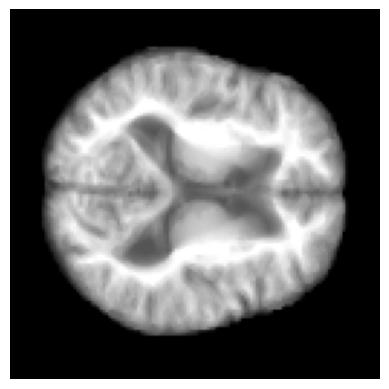

In [142]:
images = images / 255.0
plt.imshow(images[0], cmap='gray')  # Assuming it's a grayscale image
plt.axis('off')  # Hide axes
plt.show()

In [143]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

In [144]:
# from collections import Counter
# from imblearn.over_sampling import SMOTE

# images = images / 255.0

# labels = np.array([0 if x == 0. else 1 if x == 0.5 else 2 for x in labels])

# print("Original distribution:", Counter(labels))

# # Split data
# X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# # Calculate the desired number of samples for each class
# total_samples = 233
# num_classes = 3
# desired_samples_per_class = total_samples // num_classes

# # Apply SMOTE with custom sampling strategy
# smote = SMOTE(sampling_strategy={0: desired_samples_per_class, 1: desired_samples_per_class, 2: desired_samples_per_class}, random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# # Reshape back to original dimensions
# X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 128, 128, 1))

# # Show distribution after SMOTE
# print("Distribution after SMOTE:", Counter(y_train_resampled))

In [145]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    #Dense(1, activation='sigmoid')  # Use 'softmax' if you have more than 2 classes
    Dense(3, activation='softmax')
])

In [146]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #sparse_categorical_crossentropy
              metrics=['accuracy'])

In [147]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
6/6 [==============================] - 35s 6s/step - loss: 1.0278 - accuracy: 0.5092 - val_loss: 1.0181 - val_accuracy: 0.5571
Epoch 2/20
6/6 [==============================] - 11s 2s/step - loss: 0.9496 - accuracy: 0.5890 - val_loss: 1.0043 - val_accuracy: 0.5571
Epoch 3/20
6/6 [==============================] - 5s 797ms/step - loss: 1.0249 - accuracy: 0.5828 - val_loss: 0.9816 - val_accuracy: 0.5571
Epoch 4/20
6/6 [==============================] - 5s 828ms/step - loss: 0.9860 - accuracy: 0.5706 - val_loss: 0.9294 - val_accuracy: 0.5571
Epoch 5/20
6/6 [==============================] - 8s 1s/step - loss: 0.9837 - accuracy: 0.5828 - val_loss: 0.9143 - val_accuracy: 0.5571
Epoch 6/20
6/6 [==============================] - 5s 817ms/step - loss: 0.9625 - accuracy: 0.5828 - val_loss: 0.9417 - val_accuracy: 0.5571
Epoch 7/20
6/6 [==============================] - 6s 1s/step - loss: 0.9943 - accuracy: 0.5828 - val_loss: 0.9903 - val_accuracy: 0.5571
Epoch 8/20
6/6 [==============

3/3 [==============================] - 1s 238ms/step - loss: 0.9344 - accuracy: 0.5571

Test accuracy: 0.5571428537368774

Test loss: 0.9344161152839661


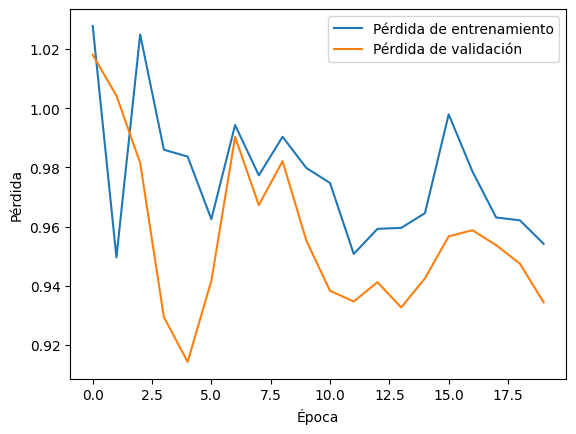

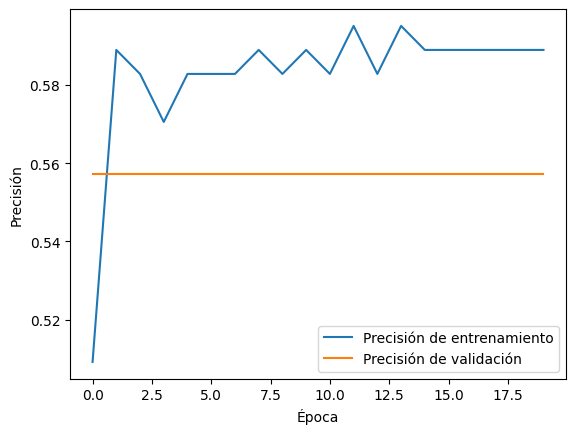

In [148]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

# Gráfico de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Gráfico de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Mejoras

In [149]:
import keras_tuner as kt
from tensorflow.keras.regularizers import l2
def build_model(hp):
    model = Sequential()

    # Primera capa de convolución
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(128, 128, 1),
        kernel_regularizer=l2(hp.Float('conv_1_l2', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Segunda capa de convolución
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Float('conv_2_l2', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Tercera capa de convolución
    model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Float('conv_3_l2', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Cuarta capa de convolución adicional
    model.add(Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_4_kernel', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Float('conv_4_l2', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Primera capa densa
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('dense_1_l2', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    ))
    model.add(Dropout(rate=hp.Float('dropout_1_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Segunda capa densa adicional
    model.add(Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('dense_2_l2', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    ))
    model.add(Dropout(rate=hp.Float('dropout_2_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Inicializar Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Definir la función de callback para detener temprano si no hay mejoras
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Buscar los mejores hiperparámetros
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[stop_early])

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el modelo con los mejores hiperparámetros y entrenarlo
hyper_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from my_dir/cnn_tuning/tuner0.json


In [150]:
history_hyper = hyper_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
6/6 [==============================] - 24s 4s/step - loss: 1.3212 - accuracy: 0.4724 - val_loss: 0.9301 - val_accuracy: 0.5571
Epoch 2/20
6/6 [==============================] - 18s 3s/step - loss: 1.3314 - accuracy: 0.4847 - val_loss: 2.1870 - val_accuracy: 0.5571
Epoch 3/20
6/6 [==============================] - 28s 5s/step - loss: 1.0013 - accuracy: 0.5399 - val_loss: 4.2493 - val_accuracy: 0.5571
Epoch 4/20
6/6 [==============================] - 19s 3s/step - loss: 0.9073 - accuracy: 0.5460 - val_loss: 7.2362 - val_accuracy: 0.5571
Epoch 5/20
6/6 [==============================] - 19s 3s/step - loss: 0.8975 - accuracy: 0.5951 - val_loss: 7.5719 - val_accuracy: 0.5571
Epoch 6/20
6/6 [==============================] - 19s 3s/step - loss: 0.9472 - accuracy: 0.5706 - val_loss: 6.1957 - val_accuracy: 0.5571
Epoch 7/20
6/6 [==============================] - 19s 3s/step - loss: 0.9230 - accuracy: 0.5828 - val_loss: 6.4020 - val_accuracy: 0.5571
Epoch 8/20
6/6 [==================

3/3 [==============================] - 2s 408ms/step - loss: 1.4493 - accuracy: 0.5571

Test accuracy: 0.5571428537368774

Test loss: 1.449286699295044


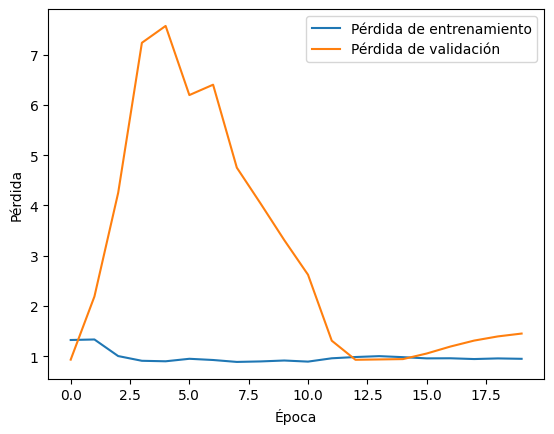

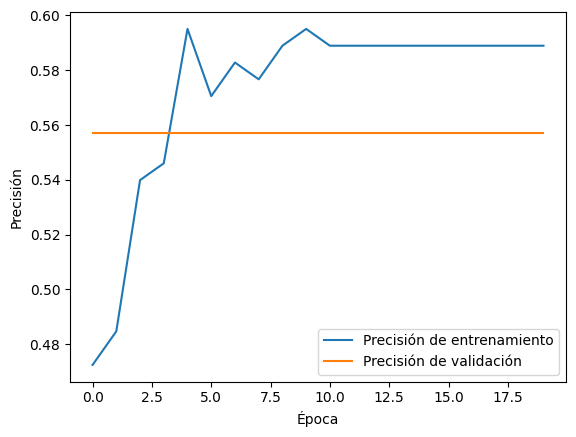

In [151]:
test_loss, test_acc = hyper_model.evaluate(X_val, y_val)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

# Gráfico de pérdida
plt.plot(history_hyper.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_hyper.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Gráfico de precisión
plt.plot(history_hyper.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_hyper.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [152]:
from sklearn.metrics import classification_report

y_val_pred = hyper_model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Generate classification report
report = classification_report(y_val, y_val_pred_classes, target_names=['class 0', 'class 0.5', 'class 1'])
print(report)

3/3 [==============================] - 3s 674ms/step
              precision    recall  f1-score   support

     class 0       0.56      1.00      0.72        39
   class 0.5       0.00      0.00      0.00        25
     class 1       0.00      0.00      0.00         6

    accuracy                           0.56        70
   macro avg       0.19      0.33      0.24        70
weighted avg       0.31      0.56      0.40        70



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Los resultados muestran que los labels están desbalanceados, esto se debe a que no todas las imágenes tienen un label por lo que no se pudo usar todas (233 de 436). Una mayor cantidad de imágenes podriá proveer un mejor resultado. Asimismo, se opto por incrementar el tamaño de la data de entrenamiento y se obersvó una mejora.**